# Installing necessary dependencies

In [ ]:
# %pip install -Uq 'unstructured[pdf]' pillow lxml
# %pip install -Uq chromadb tiktoken redis
# %pip install -Uq langchain langchain-community langchain-anthropic langchain-groq langchain-ollama
# %pip install -Uq python-dotenv

# Redis config

Prepare redis for chunk caching

In [2]:
from redis import Redis

redis = Redis(decode_responses=True)

try:
    redis.ping()
    print("Redis is ready")
except Exception as e:
    print("Redis is not ready", e)
    raise e

Redis is ready


# Data extraction

Extract the element of the PDF. Could be: Text, Images, Tables, etc.

In [3]:
from unstructured.partition.pdf import partition_pdf

OUTPUT_PATH = './pdf/'
FILENAME = 'Photography-101-Pocket-Guide.pdf'
FILEPATH = OUTPUT_PATH + FILENAME
KEY = FILENAME.split('.')[0]

def extract_images_from_chunk(chunks):
    images = []
    for chunk in chunks:
        elements = chunk.metadata.orig_elements
        for el in elements:
            if 'Image' in str(type(el)):
                images.append(el.metadata.image_base64)
    return images

if not redis.keys(f'{FILENAME.split(".")[0]}:*'):
    print('[INFO] Partitioning PDF and storing in Redis')
    chunks = partition_pdf(
        filename=FILEPATH,
        extract_image_block_types=['Image'],
        extract_image_block_to_payload=True, # if True, will extract base64
        chunking_strategy='by_title', # 'by_title' or 'basic'
        max_characters=10000,
        combine_text_under_n_chars=2000,
        new_after_n_chars=6000
    )

    print(f'[INFO] Total data chunk: {len(chunks)}')

    texts = [chunk for chunk in chunks if 'CompositeElement' in str(type(chunk))]
    images = extract_images_from_chunk(texts)
    texts = [chunk.text for chunk in texts]

    for i, text in enumerate(texts):
        key = KEY + f':text_{i}'
        text_byte = text.encode('utf-8')
        redis.set(key, text_byte)

    for i, image in enumerate(images):
        key = KEY + f':image_{i}'
        image_byte = image.encode('utf-8')
        redis.set(key, image_byte)

    
    chunks = {'text': texts, 'image': images}
    print('[INFO] Chunks stored in Redis')
else:
    print('[INFO] Fetching data from Redis')
    chunks = {'text': [], 'image': []}
    for key in redis.keys(f'{KEY}:*'):
        if 'text_' in key:
            chunks['text'] += [redis.get(key)]
        elif 'image_' in key:
            chunks['image'] += [redis.get(key)]

[INFO] Fetching data from Redis


Display the image example

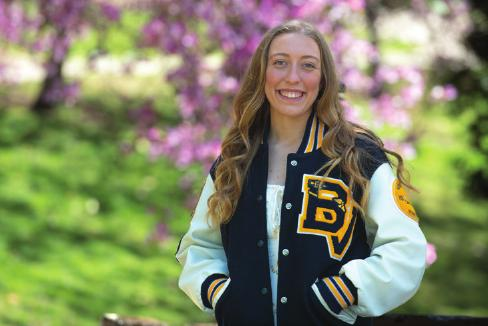

In [4]:
import base64
from IPython.display import display, Image

def display_base64(base64_code):
    image_data = base64.b64decode(base64_code)
    display(Image(image_data))

display_base64(chunks['image'][0])

In [5]:
chunks['text']

['the shot.\n\nEXPOSURE BRACKETING/HDR PHOTOGRAPHY\n\nBracketing is a technique where you take a series of images with a set exposure difference (such as one or two stops) between each photo. This allows you to capture all the avail- able photographic data in a scene—including details in both highlights and shadows—and then combine them (sometimes\n\n25\n\nin the camera, but mostly in software such as Adobe Lightroom) to create a high-dynamic range (HDR) image.\n\nBusine\n\nUSING THE HISTOGRAM\n\nA histogram is a graphical representation showing the distri- bution of tones in your image. The left side of the histogram represents the shadows and dark areas, while the right side represents the highlights and bright areas. Any data that is pure black (on the left of the graph) or pure white (on the right of the graph) is usually unwanted. You can use the histogram as a guide to help you gauge your exposure.\n\nSome photographers also use the histogram when shooting to employ a technique c

In [6]:
print(f'Total text chunk: {len(chunks["text"])}')
print(f'Total image chunk: {len(chunks["image"])}')

Total text chunk: 15
Total image chunk: 41


# Summarize the data

In [7]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

RAW_PROMPT_TEXT = """Summarize the following text in a concise, relevant manner. 
Do not provide any introduction, explanation, disclaimers, or personal remarks. 
Only present the summarized content. 
Use the text below as your source material, and respond with the condensed version of that text alone, without additional context or commentary.

Text chunk: 
{element}
"""

PROMPT_TEXT = ChatPromptTemplate.from_template(RAW_PROMPT_TEXT)

# text summary chain
text_summarizer = ChatGroq(model="llama-3.1-8b-instant", temperature=0.5, api_key=os.getenv('GROQ_API_KEY'))
summarize_chain = PROMPT_TEXT | text_summarizer | StrOutputParser()

### Text summary

In [8]:
text_summarize = summarize_chain.batch(chunks['text'], {'max_concurrency': 3})

In [9]:
print(f'Total text summary: {len(text_summarize)}')
text_summarize

Total text summary: 15


['Bracketing is a technique where you take multiple images with varying exposure to capture scene details in both highlights and shadows. These images are combined to create a high-dynamic range (HDR) image. \n\nA histogram shows the distribution of tones in an image, and can be used to gauge exposure. To optimize exposure, "expose to the right" by placing peaks in the histogram near the right edge, then adjust later in post-processing.\n\nDivide a scene into thirds using vertical and horizontal lines, and place the subject at the intersection points. The horizon line should be at the top or bottom third for landscape photography, and eyes should be aligned with the top third for portrait photography.',
 '05 ADVANCED SHOOTING TECHNIQUES\n- AUTO ISO: 24\n- BACK BUTTON FOCUS: 24\n- FOCUS AND COMPOSITION: 25\n- EXPOSURE BRACKETING/HDR PHOTOGRAPHY: 25\n- USING THE HISTOGRAM: 26\n\n06 COMPOSITION TIPS\n- RULE OF THIRDS: 27\n- FILL THE FRAME: 28\n- NEGATIVE SPACE: 29\n- LEADING LINES: 30\n- 

### Image summary

In [10]:
from langchain_anthropic import ChatAnthropic

RAW_PROMPT_IMAGE = """Describe the image in detail. For context, the image is part of a photography book explaining the concept of photography
"""

MESSAGES = [
    (
        'user',
        [
            {'type': 'text', 'text': RAW_PROMPT_IMAGE},
            {
                'type': 'image_url',
                'image_url': {'url': 'data:image/jpeg;base64,{image}'}
            }
        ]
    )
]

PROMPT_IMAGE = ChatPromptTemplate.from_messages(MESSAGES)
image_summarizer = ChatAnthropic(model='claude-3-5-sonnet-20241022', api_key=os.getenv('ANTHROPIC_API_KEY'))
describe_chain = PROMPT_IMAGE | image_summarizer | StrOutputParser()

In [11]:
import time

batch_size = 5
image_summarize = []

for i in range(0, len(chunks['image']), batch_size):
    batch = chunks['image'][i:i + batch_size]
    image_summarize += describe_chain.batch(batch)
    time.sleep(60)

In [12]:
print(f'Total image summary: {len(image_summarize)}')
image_summarize

Total image summary: 41


['This image demonstrates excellent portrait photography technique, particularly in terms of composition and background choice. The subject is wearing a classic varsity letter jacket in black and white with a yellow "B" logo, likely representing their school. The background features beautiful purple blossoms and green foliage, creating a soft, natural bokeh effect that doesn\'t compete with the subject. The shallow depth of field helps separate the subject from the background while keeping them sharp and in focus.\n\nThe lighting appears to be natural, likely during the "golden hour" or in slightly overcast conditions, which provides even, flattering illumination. The composition follows the rule of thirds, with the subject positioned slightly off-center, creating a more dynamic and interesting image. The color palette is particularly harmonious, with the purple flowers complementing the black and white of the varsity jacket.\n\nThis photo serves as a good example of how to create an e

# Initialize vector store

In [13]:
from langchain.vectorstores import Chroma
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain.storage import InMemoryStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

vectorstore = Chroma(collection_name=KEY, embedding_function=OllamaEmbeddings(model='nomic-embed-text'))

# storage layer for parent documents
docstore = InMemoryStore()
id_key = 'doc_id'

# retriever layer
retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=docstore, id_key=id_key)

USER_AGENT environment variable not set, consider setting it to identify your requests.
/var/folders/17/504r7zwd36jcb_pwxly46r940000gn/T/ipykernel_66868/2158024102.py:6: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name=KEY, embedding_function=OllamaEmbeddings(model='nomic-embed-text'))


Upsert summaries to the vector database and link to original data

In [14]:
from uuid import uuid4
from langchain_core.documents import Document

# upsert text
doc_ids = [str(uuid4()) for _ in chunks['text']]
summary_texts = [
    Document(
        page_content=summary,
        metadata={id_key: doc_ids[i]}
    ) for i, summary in enumerate(text_summarize)
]

retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, chunks['text'])))

# upser image summary
img_ids = [str(uuid4()) for _ in chunks['image']]
summary_images = [
    Document(
        page_content=summary,
        metadata={id_key: img_ids[i]}
    ) for i, summary in enumerate(image_summarize)
]

retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(img_ids, chunks['image'])))

### Testing

In [15]:
retriever.invoke('what is bracketing?')

['the shot.\n\nEXPOSURE BRACKETING/HDR PHOTOGRAPHY\n\nBracketing is a technique where you take a series of images with a set exposure difference (such as one or two stops) between each photo. This allows you to capture all the avail- able photographic data in a scene—including details in both highlights and shadows—and then combine them (sometimes\n\n25\n\nin the camera, but mostly in software such as Adobe Lightroom) to create a high-dynamic range (HDR) image.\n\nBusine\n\nUSING THE HISTOGRAM\n\nA histogram is a graphical representation showing the distri- bution of tones in your image. The left side of the histogram represents the shadows and dark areas, while the right side represents the highlights and bright areas. Any data that is pure black (on the left of the graph) or pure white (on the right of the graph) is usually unwanted. You can use the histogram as a guide to help you gauge your exposure.\n\nSome photographers also use the histogram when shooting to employ a technique c